# AIML331 Assignment 3
### crowelenn, 300607096

In this assignment, we focus on using modern machine learning techniques to classify animals from the OxfordIIITPet dataset. The animals are to be classified into the following categories:

- long-haired cat
- short-haired cat
- long-haired dog
- short-haired dog

In the first part of the assignment, we will train and evaluate a convolutional neural network to perform this task.

#### Setup
Import libraries, and load the dataset. The function to load the dataset has been provided in `dataset_wrapper` and the data is stored in the `./data` local directory.

In [1]:
from dataset_wrapper import get_pet_datasets
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

In [2]:
train_dataset, val_dataset, test_dataset = get_pet_datasets(img_width=128, img_height=128,root_path='./data' )

In [3]:
print(f"Loaded data, train = {len(train_dataset)}, test = {len(test_dataset)}")

Loaded data, train = 5719, test = 716


In [4]:
# check that cuda is working
torch.cuda.is_available()

True

#### Dataloaders, training devices etc
All the pytorch stuff that isn't the neural network itself

In [5]:
# define the compute device
compute_device = torch.device('cuda:0')

In [6]:
# load the datasets
batch_size = 64
training_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

testing_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#### Defining the neural network

**Task 1**:  Build a CNN architecture from scratch using PyTorch. You may utilise basic layers and components provided by PyTorch (e.g., Conv2D, BatchNorm2D, MaxPool2D, Linear, ReLU), but you are required to design and assemble the overall model architecture (including the loss function) independently

In [8]:
class PetsConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(PetsConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # l1 output dim = 128 - 5 + 1 + 2*2 / 2
        #               = 64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # l2 output dim = 64 - 5 + 1 + 2*2 / 2
        #               = 32

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # l3 output dim = 32 - 5 + 1 + 2*2 / 2
        #               = 16

        self.fc = nn.Linear(16*16*64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

#### Functions for training & testing

In [9]:
def do_training(model, experiment_name, criterion, optimizer, num_epochs=20, patience=5):
    writer = SummaryWriter('runs/'+experiment_name)

    min_validation_loss = None
    best_model_state = None # store the best model here. Re-instate this if early stopping is triggered
    wait = 0

    # make sure the model is starting with new weights
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    steps = len(training_dataloader)
    for epoch in range(num_epochs): # epoch iteration loop
        model.train()
        train_loss_epoch_total = 0
        batches_count = 0

        for i, (images, labels) in enumerate(training_dataloader):

            if i == 0:
                writer.add_graph(model, images.to(compute_device))
            images = images.to(compute_device)
            labels = labels.to(compute_device)

            # forwards
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backpropogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_epoch_total += loss.item()
            batches_count += 1

        train_loss = train_loss_epoch_total / batches_count
        writer.add_scalar('Loss/train', train_loss, epoch+1)

        # validation accuracy
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss_epoch_total = 0
            val_batches_count = 0

            for images, labels in validation_dataloader:
                images = images.to(compute_device)
                labels = labels.to(compute_device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)

                val_loss_epoch_total += val_loss.item()
                val_batches_count += 1

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_loss = val_loss_epoch_total / val_batches_count

        writer.add_scalar('Accuracy/validation', val_acc, epoch)
        writer.add_scalar('Loss/validation', val_loss, epoch)

        if min_validation_loss is None or val_loss < min_validation_loss:
            min_validation_loss = val_loss
            best_model_state = model.state_dict() # save the best weights
            wait = 0
        else:
            wait += 1

        if wait >= patience:
            break # exit early if there has been no improvement in validation loss

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Best model weights restored.")

    writer.close()

    return model

In [10]:
def do_testing(model, dataloader):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in dataloader:
            images = images.to(compute_device)
            labels = labels.to(compute_device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total

        return accuracy, 'Accuracy of the model on the provided images: {} %'.format(accuracy)


**Task 2** Train the model for a few epochs until the loss value stabilises or flattens, indicating convergence (normally within 20 epochs for this dataset)

In [11]:
baseline_model = PetsConvNet(num_classes=4).to(compute_device)
weights = [600/7149, 1771/7149, 2590/7149, 2188/7149]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.01)

In [12]:
baseline_num_params = sum(param.numel() for param in baseline_model.parameters())
print(f"Parameters count = {baseline_num_params}")

Parameters count = 131076


In [11]:
baseline_model_trained = do_training(baseline_model, experiment_name='cnn_baseline', criterion=criterion, optimizer=optimizer, num_epochs=50, patience=10)

Best model weights restored.


In [12]:
acc, acc_string = do_testing(baseline_model_trained, validation_dataloader)

In [13]:
print(acc_string)

Accuracy of the model on the provided images: 46.9187675070028 %


The baseline model achieves a test accuracy of 49.72%. This is good considering training the model from scratch on only ~5000 images.

### Experiments
In the `cnn_models` file I have defined the following classes:

- PetsConvNetBaseline - this was defined in the question1.ipynb
- PetsConvNetNoBatchNorm - baseline without batch normalization
- PetsConvNetLeakyRelu - baseline with a leakyReLU activation function
- PetsConvNetGelu - baseline with a GELU activation function
- PetsConvNetL5 - baseline with 5 layers
- PetsConvNetL7 - baseline with 7 layers

Each of these will be trained & evaluated with the functions above to fairly compare their performance.

In [15]:
from cnn_models import PetsConvNetNoBatchNorm, PetsConvNetLeakyRelu, PetsConvNetGelu, PetsConvNetL5, PetsConvNetL7

In [14]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
learningrate = 0.01
epochs = 50
patience = 10

#### Define the Models

In [16]:
nobatchnorm_model = PetsConvNetNoBatchNorm(num_classes=4).to(compute_device)

leakyrelu_model = PetsConvNetLeakyRelu(num_classes=4).to(compute_device)
gelu_model = PetsConvNetGelu(num_classes=4).to(compute_device)

L5_model = PetsConvNetL5(num_classes=4).to(compute_device)
L7_model = PetsConvNetL7(num_classes=4).to(compute_device)

In [30]:
models_params = [baseline_model, nobatchnorm_model, leakyrelu_model, gelu_model, L5_model, L7_model]
model_param_counts = []

for i in range(len(models_params)):
    model_param_counts.append(sum(param.numel() for param in models_params[i].parameters()))

(array([4., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([130852., 181428., 232004., 282580., 333156., 383732., 434308.,
        484884., 535460., 586036., 636612.]),
 <BarContainer object of 10 artists>)

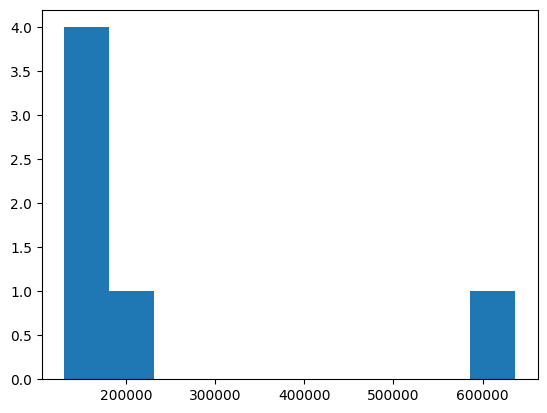

In [31]:
import matplotlib.pyplot as plt
plt.hist(model_param_counts)

#### No Batch Normalization

In [15]:
optimizer = torch.optim.Adam(nobatchnorm_model.parameters(), lr=learningrate)

nobatchnorm_model_trained = do_training(nobatchnorm_model, experiment_name='cnn_no_batchnorm', criterion=criterion, optimizer=optimizer, num_epochs=epochs, patience=patience)
acc, acc_string = do_testing(nobatchnorm_model_trained, validation_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 34.593837535014 %


#### Leaky ReLU

In [16]:
optimizer = torch.optim.Adam(leakyrelu_model.parameters(), lr=learningrate)

leakyrelu_model_trained = do_training(leakyrelu_model, experiment_name='cnn_leaky_relu', criterion=criterion, optimizer=optimizer, num_epochs=epochs, patience=patience)
acc, acc_string = do_testing(leakyrelu_model_trained, validation_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 45.65826330532213 %


#### GELU

In [17]:
optimizer = torch.optim.Adam(gelu_model.parameters(), lr=learningrate)

gelu_model_trained = do_training(gelu_model, experiment_name='cnn_gelu', criterion=criterion, optimizer=optimizer, num_epochs=epochs, patience=patience)
acc, acc_string = do_testing(gelu_model_trained, validation_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 47.05882352941177 %


#### 5 Layers

In [18]:
optimizer = torch.optim.Adam(L5_model.parameters(), lr=learningrate)

L5_model_trained = do_training(L5_model, experiment_name='cnn_L5', criterion=criterion, optimizer=optimizer, num_epochs=epochs, patience=patience)
acc, acc_string = do_testing(L5_model_trained, validation_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 51.680672268907564 %


#### 7 Layers

In [19]:
optimizer = torch.optim.Adam(L7_model.parameters(), lr=learningrate)

L7_model_trained = do_training(L7_model, experiment_name='cnn_L7', criterion=criterion, optimizer=optimizer, num_epochs=epochs, patience=patience)
acc, acc_string = do_testing(L7_model_trained, validation_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 56.72268907563025 %


### Residual Integration
Modify your CNN architecture to incorporate a residual connection around the CNN layer. Specifically, instead of computing the output as CNN(x), the modified network should compute the output as x + CNN(x), enabling the model to learn residual mappings.

I decided it would make most sense to re-build the 7-layer CNN with skip connections, as this has the most parameters and is most likely to overfit.

In [61]:
# the network with skip connections is going to be made up of these
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, downsample=False):
        super(ResNetBlock, self).__init__()

        pooling_factor = 2 if downsample else 1 # downsample by a factor of 2
        padding = (kernel_size - 1) // 2

        self.convolution1 = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=pooling_factor,
                                      padding=padding,
                                      bias=False)

        self.relu = nn.ReLU(inplace=True)
        self.BatchNorm = nn.BatchNorm2d(out_channels)

        self.downsample_skip = None

        # if we are downsampling or changing the number of channels,
        #   then we will need to apply this to the x 'skip connection'
        #   input too, otherwise the piecewise addition will fail
        if downsample or in_channels != out_channels:
            self.downsample_skip = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels,
                          kernel_size=1,
                          stride=pooling_factor,
                          bias=False), # BatchNorm has a bias so this is redundant
                nn.BatchNorm2d(out_channels)
            )

        self.BatchNorm2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        input = x # save the original input here

        # push the input through the 'regular' CNN components
        out = self.BatchNorm(self.relu(self.convolution1(x)))
        #out = self.relu(self.BatchNorm(self.convolution1(x)))

        # I could add more batch normalization?

        # if downsampling, then this will be defined. The input needs to be transformed
        if self.downsample_skip is not None:
            input = self.downsample_skip(x)

        # piecewise addition for the skip connection
        out += input

        # experimental
        out = self.relu2(self.BatchNorm2(out))

        return out


In [34]:
class PetsConvNetSkipConnectionL3(nn.Module):
    def __init__(self, num_classes=4):
        super(PetsConvNetSkipConnectionL3, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # l1 output dim = 128 - 5 + 1 + 2*2 / 2
        #               = 64
        self.layer2 = ResNetBlock(16, 32, kernel_size=5, downsample=True)
        # l2 output dim = 32

        self.layer3 = ResNetBlock(32, 64, kernel_size=5, downsample=True)
        # l3 output dim = 16

        self.fc = nn.Linear(16*16*64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [62]:
class PetsConvNetSkipConnectionL7(nn.Module):
    def __init__(self, num_classes=4):
        super(PetsConvNetSkipConnectionL7, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # l1 output dim = 128 - 5 + 1 + 2*2 / 2
        #               = 64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # l2 output dim = 64 - 5 + 1 + 2*2 / 2
        #               = 32

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # l3 output dim = 32 - 5 + 1 + 2*2 / 2
        #               = 16

        # push through layers 4 & 5 before pooling
        # keep channel at 64 until layer 5
        # use 3x3 convolutions as the inputs are only 16x16 now

        self.layer4 = ResNetBlock(64, 64, kernel_size=3, downsample=False)
        # l4 output dim = 16

        self.layer5 = ResNetBlock(64, 128, kernel_size=3, downsample=True)
        # l5 output dim = 8

        self.layer6 = ResNetBlock(128, 128, kernel_size=3, downsample=False)
        # l6 output dim = 8

        self.layer7 = ResNetBlock(128, 256, kernel_size=3, downsample=True)
        # l7 output dim = 4

        self.fc = nn.Linear(4 * 4 * 256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [37]:
L3_skipconnection_model = PetsConvNetSkipConnectionL3(num_classes=4).to(compute_device)
optimizer = torch.optim.Adam(L3_skipconnection_model.parameters(), lr=learningrate)

L3_skipconnection_model_trained = do_training(L3_skipconnection_model, experiment_name='cnn_skip_L3', criterion=criterion, optimizer=optimizer, num_epochs=epochs)
acc, acc_string = do_testing(L3_skipconnection_model_trained, validation_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 34.173669467787114 %


In [65]:
L7_skipconnection_model = PetsConvNetSkipConnectionL7(num_classes=4).to(compute_device)
optimizer = torch.optim.Adam(L7_skipconnection_model.parameters(), lr=learningrate)

L7_skipconnection_model_trained = do_training(L7_skipconnection_model, experiment_name='cnn_skip_L7', criterion=criterion, optimizer=optimizer, num_epochs=50, patience=10)
acc, acc_string = do_testing(L7_skipconnection_model_trained, validation_dataloader)
print(acc_string)

Best model weights restored.
Accuracy of the model on the provided images: 43.13725490196079 %


## Final Model Testing
Until now, the models have only been evaluated on the validation set. They should be evaluated on the Testing set to assess their generalisation performance.

In [25]:
# Baseline Model
print(do_testing(baseline_model_trained, testing_dataloader)[1])

Accuracy of the model on the provided images: 49.16201117318436 %


In [26]:
print(do_testing(nobatchnorm_model_trained, testing_dataloader)[1])

Accuracy of the model on the provided images: 39.245810055865924 %


In [27]:
print(do_testing(leakyrelu_model_trained, testing_dataloader)[1])

Accuracy of the model on the provided images: 50.977653631284916 %


In [28]:
print(do_testing(gelu_model_trained, testing_dataloader)[1])

Accuracy of the model on the provided images: 47.90502793296089 %


In [29]:
print(do_testing(L5_model_trained, testing_dataloader)[1])

Accuracy of the model on the provided images: 52.23463687150838 %


In [30]:
print(do_testing(L7_model_trained, testing_dataloader)[1])

Accuracy of the model on the provided images: 56.28491620111732 %


In [31]:
print(do_testing(L3_skipconnection_model_trained, testing_dataloader)[1])

Accuracy of the model on the provided images: 43.99441340782123 %


In [32]:
print(do_testing(L7_skipconnection_model_trained, testing_dataloader)[1])

Accuracy of the model on the provided images: 49.16201117318436 %


### Testing the inference time
I am training a new baseline model, as I have already written the bulk of the report, and don't want to have to update the baseline model accuracy & figures throughout.

In [34]:
baseline_model_inference = PetsConvNet(num_classes=4).to(compute_device)
weights = [600 / 7149, 1771 / 7149, 2590 / 7149, 2188 / 7149]
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(baseline_model_inference.parameters(), lr=0.01)

baseline_model_inference = do_training(baseline_model_inference, experiment_name='cnn_baseline', criterion=criterion, optimizer=optimizer, num_epochs=50, patience=10)

Best model weights restored.


In [33]:
import time

baseline_model_inference.eval()

total_time = 0.0
total_images = 0

with torch.no_grad():
    for inputs, _ in testing_dataloader:
        inputs = inputs.to(compute_device)
        batch_size = inputs.size(0)

        start_time = time.time()
        _ = baseline_model_inference(inputs)
        end_time = time.time()

        total_time += end_time - start_time
        total_images += batch_size

average_inference = total_time / total_images
print(f"Average image inference time: {average_inference}")

Average image inference time: 5.0445841677362025e-05
